#**Шлюз однонаправленной передачи данных**

##**Цель проекта**

Разработать шаблон для безопасной однонаправленной передачи данных из внутренней (защищенной) сети во внешнюю, исключающий возможность обратного потока информации и обеспечивающий контроль целостности передаваемых данных.

##**Цели безопасности**

**При применении шаблона обеспечиваются следующие цели безопасности:**-
* Гарантированная доставка данных без возможности их модификации при передаче.

##**Основная идея**

Однонаправленная передача данных критически важна для систем, где требуется исключить любой риск утечки информации из защищенной сети.
Шаблон позволяет:
*	Изолировать сети – гарантировать физическое или логическое разделение внутренней и внешней сетей.
*	Контролировать целостность – проверять, что передаваемые данные не были изменены в процессе передачи.


##**Детали реализации**

###**Компоненты системы**
*	Источник данных – внутренний модуль, формирующий данные для передачи (NavigationSystem).
*	Буфер обмена – промежуточное хранилище (unordered set), обеспечивающее временное хранение данных перед отправкой и уникальность координат.
*	Механизм передачи – функция в NavigationSystem.

###**Механизмы передачи данных**
*	Очереди сообщений – для асинхронной обработки и буферизации данных (используется multiprocessing.Queue).
*	Запись в файл – данные записываются в файл, который затем передается во внешнюю сеть (реализовано в методе writeToFileReceivedCoordinats).
*	Проверка целостности – контроль изменений данных перед передачей.

##**Преимущества шаблона**
*	Безопасность: исключает обратный поток данных.
*	Надежность: использование очередей гарантирует доставку даже при временных сбоях.
*	Масштабируемость: легко адаптируется для передачи различных типов данных.


##**Тесты**
* были написаны тесты для проверки функционала блока


##**Архитектура шаблона**



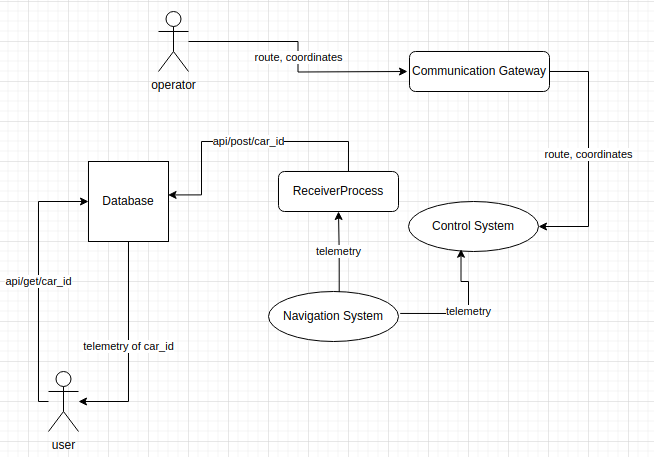

##**Реализация блока Receiver**

In [ ]:
from multiprocessing import Queue, Process
from typing import Optional, Set
from queue import Empty


from time import sleep

from src.config import RECEIVER_QUEUE_NAME
from src.queues_dir import QueuesDirectory
from src.config import CRITICALITY_STR, DEFAULT_LOG_LEVEL, LOG_DEBUG, LOG_ERROR, LOG_INFO
from src.mission_type import Mission
from src.event_types import Event, ControlEvent

class ReceiverProcess(Process):

    log_prefix = "[RECEIVER]"
    event_source_name = RECEIVER_QUEUE_NAME
    events_q_name = event_source_name
    last_coordinate = None # для прекращения записи, когда машина остановится
    unique_coordinates: Set[str] = set()

    def __init__(self, queues_dir: QueuesDirectory, log_level = DEFAULT_LOG_LEVEL):
        # вызываем конструктор базового класса
        super().__init__()

        # запоминаем каталог очередей -
        # позже он понадобится для отправки Координат В Консоль
        self._queues_dir = queues_dir

        # создаём очередь для сообщений на обработку
        self._events_q = Queue()
        self._events_q_name = self.event_source_name

        # регистрируем очередь в каталоге
        self._queues_dir.register(
            queue=self._events_q, name=self._events_q_name)

        # инициализируем интервал обновления
        self._recalc_interval_sec = 0.5

        self._quit = False
        # очередь управляющих команд (например, для остановки работы модуля)
        self._control_q = Queue()

        # координаты пункта назначения
        self._mission: Optional[Mission] = None

        self.log_level = log_level
        self._log_message(LOG_INFO, "создан компонент получения координат")

    def _log_message(self, criticality: int, message: str):
        """_log_message печатает сообщение заданного уровня критичности

        Args:
            criticality (int): уровень критичности
            message (str): текст сообщения
        """
        if criticality <= self.log_level:
            print(f"[{CRITICALITY_STR[criticality]}]{self.log_prefix} {message}")

    # проверка наличия новых управляющих команд
    def _check_control_q(self):
        try:
            request: ControlEvent = self._control_q.get_nowait()
            self._log_message(LOG_DEBUG, f"проверяем запрос {request}")
            if isinstance(request, ControlEvent) and request.operation == 'stop':
                # поступил запрос на остановку монитора, поднимаем "красный флаг"
                self._quit = True
                self._write_coordinates_to_file()
        except Empty:
            # никаких команд не поступило, ну и ладно
            pass
        try:
            event: Event = self._events_q.get_nowait()
            self._events_q.get()
            if not isinstance(event, Event):
                return
            if event.operation == 'post_coordinates':
                try:
                    self._set_mission(event.parameters)
                except Exception as e:
                    self._log_message(LOG_ERROR, f"ошибка получения координат: {e}")
        except Empty:
            # никаких команд не поступило, ну и ладно
            pass

    def _check_events_q(self):
        try:
            event: Event = self._events_q.get_nowait()
            if not isinstance(event, Event):
                return
            if event.operation == 'post_coordinates':
                try:
                    self._set_mission(event.parameters)
                except Exception as e:
                    self._log_message(LOG_ERROR, f"ошибка получения координат: {e}")
        except Empty:
            # никаких команд не поступило, ну и ладно
            pass

    def _set_mission(self, mission: Mission):
        if self.last_coordinate == mission : return
        self.last_coordinate = mission
        self._mission = mission
        self.unique_coordinates.add(str(mission))
        self._log_message(LOG_DEBUG, f"получены координаты: {self._mission}")
        self._log_message(LOG_DEBUG, "получены координаты, записываю в буфер")

    def _write_coordinates_to_file(self):
        """Записывает все уникальные координаты в файл при остановке процесса"""
        import os
        current_dir = os.path.dirname(os.path.abspath(__file__))
        file_path = os.path.join(current_dir, "telemetry.txt")

        try:
            with open(file_path, 'a', encoding='utf-8') as file:
                for coord in self.unique_coordinates:
                    file.write(f"{coord}\n")
            self._log_message(LOG_INFO, f"успешно записано {len(self.unique_coordinates)} координат в файл")
        except Exception as e:
            self._log_message(LOG_ERROR, f"ошибка записи координат в файл: {e}")
        finally:
            self.unique_coordinates.clear()  # Очищаем множество после записи

    def stop(self):
        self._control_q.put(ControlEvent(operation='stop'))

    def run(self):
        self._log_message(LOG_INFO, "старт системы планирования заданий")

        while self._quit is False:
            sleep(self._recalc_interval_sec)
            try:
                self._check_events_q()
                self._check_control_q()
            except Exception as e:
                self._log_message(LOG_ERROR, f"ошибка обновления координат: {e}")